# Intro Task, Object Localization

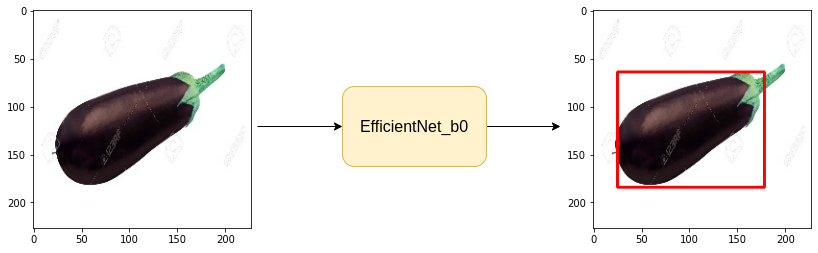

In [1]:
# # install libraries/packages/modules

# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install timm
# !pip install --upgrade opencv-contrib-python

In [2]:
# # Download Dataset

# !git clone https://github.com/parth1620/object-localization-dataset.git

In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Configurations

In [4]:
csv_file = './object-localization-dataset/train.csv'
data_dir = './object-localization-dataset/'

batch_size = 16
img_size = 140

lr = 0.001
epochs = 40
model_name = 'efficientnet_b0'

num_cor = 4

In [5]:
df = pd.read_csv(csv_file)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

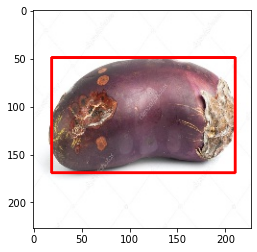

In [6]:
row = df.iloc[150]
img = cv2.imread(data_dir + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
plt.imshow(img)

In [7]:
tran_df , valid_df = train_test_split(df,test_size=0.20,random_state=42)

# Augmentations

In [8]:
import albumentations as A

In [9]:
train_augs = A.Compose([
    A.Resize(img_size,img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params= A.BboxParams(format ="pascal_voc",label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(img_size,img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params= A.BboxParams(format ="pascal_voc",label_fields = ['class_labels']))

# Create Custom Dataset

In [10]:
class ObjectLocDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin,ymin,xmax,ymax]]

        img_path = data_dir + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
            data = self.augmentations(image = img , bboxes=bbox,class_labels = [None])
            img = data['image']
            bbox = data['bboxes'][0]
        img = torch.from_numpy(img).permute(2,0,1)/255.0
        bbox = torch.Tensor(bbox)

        return img,bbox


In [11]:
trainset = ObjectLocDataset(tran_df,train_augs)
validset = ObjectLocDataset(valid_df,valid_augs)

In [12]:
print(len(trainset))
print(len(validset))

148
38


In [13]:
trainset[1]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([ 34.5374,   9.2511,  89.4273, 118.4141]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


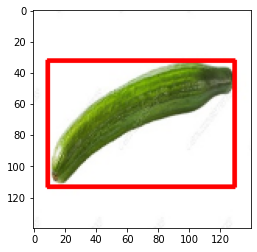

In [14]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, shuffle = True)
validloader = torch.utils.data.DataLoader(validset,batch_size = batch_size, shuffle = False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images , bboxes in trainloader:
    break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn
import timm

In [29]:
class ObjLocModel(nn.Module):

    def __init__(self):
        super(ObjLocModel,self).__init__()
        
        self.backbone = timm.create_model(model_name, pretrained = True, num_classes=4)

    def forward(self, images, gt_bboxes = None):
        bboxes = self.backbone(images)
        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes,gt_bboxes)
            return bboxes,loss
        return bboxes


In [30]:
model = ObjLocModel()

In [31]:
model

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [32]:
random_img = torch.rand(1,3,140,140)
model(random_img).shape


torch.Size([1, 4])

# Create Train and Eval Function

In [40]:
def train_fn(model,dataloader,optmizer):
    total_loss = 0.0
    model.train()

    for data in dataloader:
        images, gt_bboxes = data
        
        bboxes , loss = model(images,gt_bboxes)

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        total_loss += loss.item()

        return total_loss/len(dataloader)

In [41]:
def eval_fn(model,dataloader):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            images, gt_bboxes = data
            
            bboxes , loss = model(images,gt_bboxes)
            total_loss += loss.item()

            return total_loss/len(dataloader)

# Training Loop

In [42]:
optmizer = torch.optim.Adam(model.parameters(),lr = lr)

In [43]:
best_valid_loss = np.Inf

for i in range(epochs):
    train_loss = train_fn(model,trainloader,optmizer)
    valid_loss = eval_fn(model,validloader)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_valid_loss = valid_loss
    print(f'Epoch: {i+1} Train Loss:{train_loss} Valid Loss:{valid_loss}')

Model Saved
Epoch: 1 Train Loss:133.98662109375 Valid Loss:747.276123046875
Model Saved
Epoch: 2 Train Loss:183.162646484375 Valid Loss:346.3914388020833
Model Saved
Epoch: 3 Train Loss:111.74781494140625 Valid Loss:318.49114990234375
Model Saved
Epoch: 4 Train Loss:127.3898193359375 Valid Loss:188.4862263997396
Epoch: 5 Train Loss:126.01619873046874 Valid Loss:194.9312947591146
Epoch: 6 Train Loss:129.041455078125 Valid Loss:245.02327473958334
Model Saved
Epoch: 7 Train Loss:118.611328125 Valid Loss:170.9600626627604
Epoch: 8 Train Loss:98.2470947265625 Valid Loss:183.0
Model Saved
Epoch: 9 Train Loss:98.823095703125 Valid Loss:114.40807088216145
Model Saved
Epoch: 10 Train Loss:71.58822631835938 Valid Loss:95.09145100911458
Model Saved
Epoch: 11 Train Loss:73.73521728515625 Valid Loss:75.83853149414062
Epoch: 12 Train Loss:100.46026000976562 Valid Loss:78.03640747070312
Epoch: 13 Train Loss:83.03274536132812 Valid Loss:80.71463012695312
Model Saved
Epoch: 14 Train Loss:75.27572021484

# Inference

In [45]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


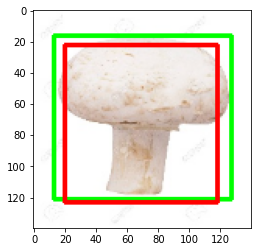

In [59]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[1] # (c,h,w)
    image = image.unsqueeze(0) # (batch_size, c ,h ,w)
    out_bbox = model(image)

    utils.compare_plots(image,gt_bbox,out_bbox)